# CS 334 Project - Group 8

In this project, we'll be working on Kaggle's [Real/Fake Job Posting Prediction](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data) dataset.

The dataset contains:
> - Contains 17880 job descriptions out of which 866 are fraudulent.
> - Consists of both textual information and meta-information about the jobs.
> - Can be used to create classification models which can learn to identify fraudulent job descriptions.

In [152]:
# importing libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
nltk.download('stopwords')


stop_words = set(stopwords.words("english"))

default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [153]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Data Science/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Data Science/Project


In [154]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Data Cleaning & Preprocessing

In [155]:
import plotly.express as px

# calculating the proportion of missing values in each column
missing_proportion = df.isnull().mean() * 100

# Create a DataFrame for plotting
missing_df = pd.DataFrame({'Columns': missing_proportion.index, 'Proportion of Missing Values (%)': missing_proportion.values})

# Create a bar plot using Plotly Express
fig = px.bar(missing_df, x='Columns', y='Proportion of Missing Values (%)',
             title='Proportion of Missing Values in Each Column',
             labels={'Columns': 'Columns', 'Proportion of Missing Values (%)': 'Proportion of Missing Values (%)'},
             hover_name='Columns', hover_data={'Proportion of Missing Values (%)': True},
             color='Proportion of Missing Values (%)', color_continuous_scale='reds',
             text=missing_df['Proportion of Missing Values (%)'].round(2).astype(str) + '%')  # Add labels with percentages

# Update layout
fig.update_layout(xaxis_tickangle=-45, xaxis_title=None, yaxis_title='Proportion of Missing Values (%)')

# Show the plot
fig.show()

In [156]:
# convverting all string values to lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# since 'department' and 'salary_range' features have a high proportion of missing values, we drop them
df = df.drop(['salary_range', 'department'], axis=1)


In [157]:
import plotly.express as px

# Create a DataFrame for counting the distribution of fraudulent job postings
fraudulent_counts = df['fraudulent'].value_counts().reset_index()
fraudulent_counts.columns = ['Fraudulent', 'Count']

# Map the values of 'Fraudulent' to labels
fraudulent_counts['Fraudulent'] = fraudulent_counts['Fraudulent'].map({0: 'Legitimate', 1: 'Fraudulent'})

# Create a bar plot using Plotly Express
fig = px.bar(fraudulent_counts, x='Fraudulent', y='Count', color='Fraudulent',
             labels={'Fraudulent': 'Fraudulent', 'Count': 'Count'},
             title='Distribution of Fraudulent Job Postings',
             text='Count')

# Update layout
fig.update_layout(xaxis_title=None, yaxis_title='Count', xaxis={'categoryorder':'total descending'}, width =500)

# Show the plot
fig.show()

In [158]:
def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text) # removes numbers from 0-9
                text =  text.lower() # converts all text to lowercase
                text = re.sub('re:', '', text) # removes any instances of the letters "re:"

                text = re.sub('-', '', text) # removes dashes
                text = re.sub('_', '', text) # removes underscores
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # removes URLs

                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE) # removes email addresses
                text =re.sub('\[[^]]*\]', '', text) # removes text between square brackets
                text = re.sub(r'[^\w\s]','',text) # removes punctuation
                text = re.sub(r'\n',' ',text) # replaces newline characters with spaces
                text = re.sub(r'[0-9]+','',text)

                # compiling a regular expression pattern to match HTML tags
                p = re.compile(r'<.*?>')

                # normalization of word contractions like I've to I have etc.
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)

                # removing HTML tags
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token

        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text)

        return text

## Exploratory Data Analysis (EDA)

Percentage of Real Job Postings: 95.1565995525727%
Percentage of Fake Job Postings: 4.8434004474272925%


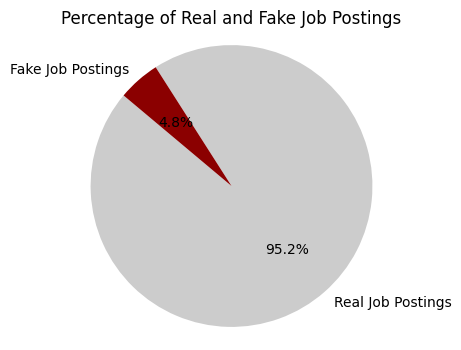

In [159]:
total_postings = len(df)

# number of real and fake job postings
real_postings = len(df[df['fraudulent'] == 0])
fake_postings = len(df[df['fraudulent'] == 1])

# percentage of real and fake job postings
real_percentage = (real_postings / total_postings) * 100
fake_percentage = (fake_postings / total_postings) * 100

print(f"Percentage of Real Job Postings: {real_percentage}%")
print(f"Percentage of Fake Job Postings: {fake_percentage}%")

# creating a pie chart
sizes = [real_percentage, fake_percentage]
labels = ['Real Job Postings', 'Fake Job Postings']

colors = ['#CCCCCC', '#8B0000']

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Percentage of Real and Fake Job Postings')
plt.axis('equal')
plt.show()

In [160]:
# Finding correlation between the numeric data
numerical = df.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numerical.corr()

# Create a heatmap using Plotly Express
fig = px.imshow(corr_matrix, color_continuous_scale='electric',
                labels=dict(x="Features", y="Features", color="Correlation"),
                title="Correlation Matrix of Numerical Variables")

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        fig.add_annotation(x=i, y=j, text=f"{corr_matrix.iloc[i, j]:.2f}",
                           showarrow=False, font=dict(color='white', size=12),
                           xshift=10, yshift=10)


# Update layout
fig.update_layout(width=600, height=500)

# Show the plot
fig.show()

In [161]:
# distribution of job postings by country
df['country'] = df['location'].str.split(',').str[0]

# mapping the country codes to their full names
country_dict = {'us': 'United States', 'gb': 'United Kingdom', 'gr': 'Greece',
                'nz': 'New Zealand', 'de': 'Germany', 'be': 'Belgium',
                'ca': 'Canada', 'in': 'India', 'au': 'Australia', 'nl': 'Netherlands',
                'fr': 'France', 'eg': 'Egypt', 'se': 'Sweden', 'ph': 'Philippines',
                'ae': 'United Arab Emirates', 'sg': 'Singapore', 'es': 'Spain',
                'ie': 'Ireland', 'dk': 'Denmark'}

df['country_full'] = df['country'].map(country_dict)


# Group the data by 'country_full' and calculate the proportion of fraudulent job postings in each country
country_proportions = df.groupby('country_full')['fraudulent'].mean().reset_index()
country_proportions.columns = ['country_full', 'proportion']

# Sort the data by the proportion of fraudulent job postings in descending order
country_proportions = country_proportions.sort_values(by='proportion', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(country_proportions, x='country_full', y='proportion',
             labels={'country_full': 'Country', 'proportion': 'Proportion of Fraudulent Job Postings'},
             title='Proportion of Fraudulent Job Postings by Country',
             width=800)

# Add labels to each bar
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')

# Show the plot
fig.show()



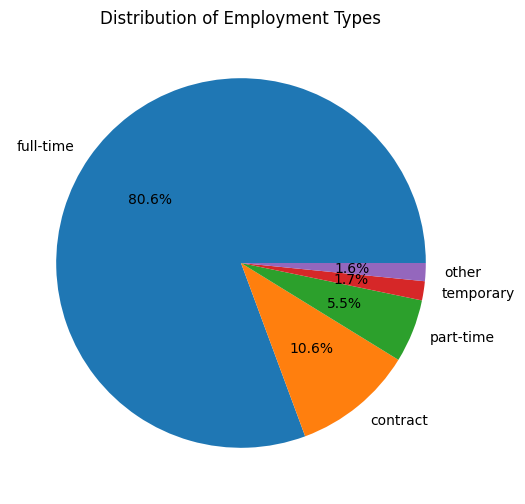

In [162]:
# distribution of employment types
employment_type_counts = df['employment_type'].value_counts()

# pie chart
plt.figure(figsize=(10, 6))
plt.pie(employment_type_counts, labels = employment_type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Employment Types')
plt.show()

In [163]:
# Filter the DataFrame for observations where fraudulent == 1
fraudulent_df = df[df['fraudulent'] == 1]

# Calculate the counts of each required experience level
required_experience_counts = fraudulent_df['required_experience'].value_counts()

# Create a bar plot using Plotly Express
fig = px.bar(x=required_experience_counts.index, y=required_experience_counts.values,
             labels={'x': 'Required Experience', 'y': 'Count'},
             title='Number of Fake Job Postings by Required Experience',
             color=required_experience_counts.index,
             width = 600)

# Update layout
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()


In [164]:
# Filter the DataFrame for observations where fraudulent == 1
fraudulent_df = df[df['fraudulent'] == 1]

# Group the filtered data by 'required_education' and count the occurrences
education_fraud_count = fraudulent_df.groupby('required_education').size().reset_index(name='count')

# Sort the DataFrame by the count in descending order
education_fraud_count_sorted = education_fraud_count.sort_values(by='count', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(education_fraud_count_sorted, x='required_education', y='count',
             labels={'required_education': 'Required Education', 'count': 'Number of Job Postings'},
             title='Number of Fake Job Postings by Required Education',
             color=education_fraud_count.index,
             width = 600)

# Annotate each bar with its count value
for index, row in education_fraud_count_sorted.iterrows():
    fig.add_annotation(x=row['required_education'], y=row['count'],
                       text=str(row['count']), showarrow=False,
                       font=dict(color='black', size=12))

# Update layout
fig.update_layout(xaxis_tickangle=-45)

# Show the plot
fig.show()


In [165]:
# Group the filtered data by 'function' and count the occurrences
function_fraud_count = fraudulent_df.groupby('function').size().reset_index(name='count')

# Sort the DataFrame by the count in descending order
function_fraud_count_sorted = function_fraud_count.sort_values(by='count', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(function_fraud_count_sorted, x='function', y='count',
             labels={'function': 'Function', 'count': 'Number of Job Postings'},
             title='Number of Fake Job Postings by Function',
             color=function_fraud_count.index,
             width=800,
            )

# Annotate each bar with its count value
for index, row in function_fraud_count_sorted.iterrows():
    fig.add_annotation(x=row['function'], y=row['count'],
                       text=str(row['count']), showarrow=False,
                       font=dict(color='black', size=12))

# Show the plot
fig.show()


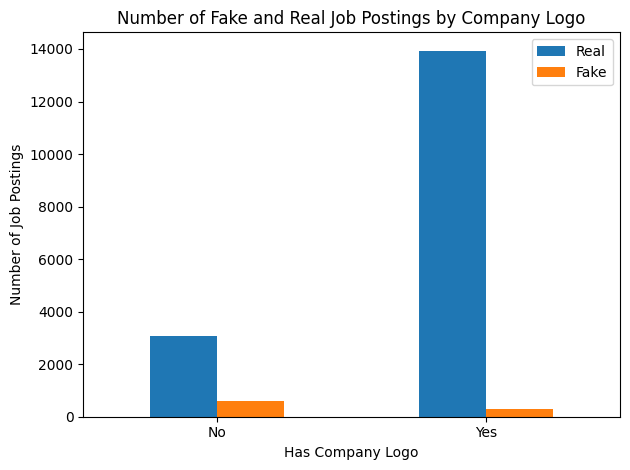

In [166]:
# number of fake and real job postings by company logo
logo_fraud_count = df.groupby(['has_company_logo', 'fraudulent']).size().unstack()

logo_fraud_count.plot(kind='bar')
plt.title('Number of Fake and Real Job Postings by Company Logo')
plt.xlabel('Has Company Logo')
plt.ylabel('Number of Job Postings')
plt.legend(['Real', 'Fake'], loc='upper right')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

In [167]:
# counts of real and fake jobs in each industry
industry_counts = df[df['fraudulent'] == 1].groupby('industry').size().reset_index(name='count')

N = 10

# sorting the industries by the number of fake jobs and selecting the top N
top_industries = industry_counts.sort_values('count', ascending=False).head(N)

# Create a bar plot using Plotly Express
fig = px.bar(top_industries, x='industry', y='count',
             labels={'industry': 'Industry', 'count': 'Number of Fake Job Postings'},
             title=f'Top {N} Industries with Most Fake Job Postings',
             width=800)

# Show the plot
fig.show()


<ipython-input-168-7f9debe29116>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




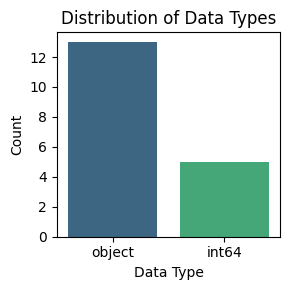

In [168]:
# Get the data types of each column
data_types = df.dtypes

# Count the number of each data type
data_type_counts = data_types.value_counts()

# Create the bar plot
plt.figure(figsize=(3, 3))
sns.barplot(x=data_type_counts.index, y=data_type_counts.values, palette='viridis')

plt.title('Distribution of Data Types')
plt.xlabel('Data Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


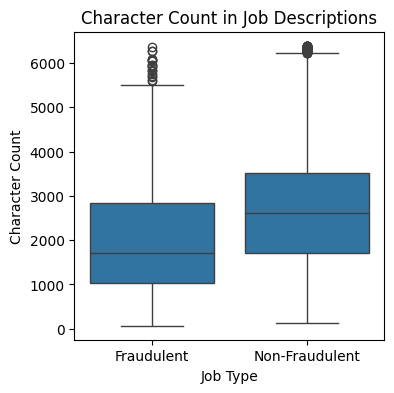

In [169]:
# combining all text columns into one
df['combined_text'] = df.select_dtypes(include=['object']).apply(lambda x: ' '.join(x.astype(str)), axis=1)

df['char_count'] = df['combined_text'].str.len()

# IQR for char_count
Q1 = df['char_count'].quantile(0.25)
Q3 = df['char_count'].quantile(0.75)
IQR = Q3 - Q1

# upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# removing outliers
df_no_outliers = df[(df['char_count'] >= lower_bound) & (df['char_count'] <= upper_bound)]

fraudulent_jobs = df_no_outliers[df_no_outliers['fraudulent'] == 1]
non_fraudulent_jobs = df_no_outliers[df_no_outliers['fraudulent'] == 0]

boxplot_df = pd.concat([fraudulent_jobs[['char_count']].assign(Job='Fraudulent'), non_fraudulent_jobs[['char_count']].assign(Job='Non-Fraudulent')])

plt.figure(figsize=(4, 4))

sns.boxplot(x='Job', y='char_count', data=boxplot_df)

plt.title('Character Count in Job Descriptions')
plt.xlabel('Job Type')
plt.ylabel('Character Count')

plt.show()

## Classification

In [170]:
new_df = df

# filling missing values
new_df.fillna(' ',inplace=True)

# concatenating all string type variables into 'text' separated by spaces
new_df['text'] = new_df[['title','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1)

# dropping all other data
new_df.drop(['job_id', 'location', 'title', 'company_profile','description','requirements','benefits'], axis=1, inplace=True)

# encoding the text data into numeric data
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  new_df[i] = lb_make.fit_transform(new_df[i])

new_df.drop(['country_full', 'combined_text', 'country'], axis=1, inplace=True)

df_columns = new_df.columns.tolist()
df_columns = df_columns[-1:] + df_columns[:-1]
label_df = df[df_columns]
label_df.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,char_count
0,"marketing intern we're food52, and we've creat...",0,1,0,3,5,0,0,23,0,2734
1,customer service - cloud video production 90 s...,0,1,0,2,7,0,76,8,0,6235
2,commissioning machinery assistant (cma) valor ...,0,1,0,0,0,0,0,0,0,2694
3,account executive - washington dc our passion ...,0,1,0,2,6,2,23,32,0,5567
4,bill review manager spotsource solutions llc i...,0,1,1,2,6,2,52,17,0,4074


In [171]:
# cleaning the text
label_df['text'] = label_df['text'].apply(clean_text)
label_df['text'].head()

0    market intern food weve creat groundbreak awar...
1    custom servic cloud video product second world...
2    commiss machineri assist cma valor servic prov...
3    account execut washington dc passion improv qu...
4    bill review manag spotsourc solut llc global h...
Name: text, dtype: object

In [172]:
# converting the text data into TF-IDF matrix
cv = TfidfVectorizer(max_features=100)
x = cv.fit_transform(label_df['text'])

feature_names = cv.get_feature_names_out()
df1 = pd.DataFrame(x.toarray(), columns=feature_names)
dummy_df = label_df
main_df = pd.concat([df1, dummy_df], axis=1)

main_df.drop(['char_count', 'text'], axis=1, inplace=True)
main_df

,abil,account,also,amp,applic,base,benefit,best,build,busi,...,year,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.000000,0.000000,0.122895,0.108523,0.000000,0.000000,0.000000,0.126546,0.000000,0.096202,...,0.000000,0,1,0,3,5,0,0,23,0
1,0.000000,0.041676,0.033662,0.059451,0.000000,0.061661,0.000000,0.000000,0.000000,0.105402,...,0.000000,0,1,0,2,7,0,76,8,0
2,0.000000,0.000000,0.000000,0.092739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,1,0,0,0,0,0,0,0
3,0.040064,0.580023,0.000000,0.000000,0.000000,0.000000,0.091887,0.000000,0.121006,0.300054,...,0.060210,0,1,0,2,6,2,23,32,0
4,0.000000,0.109388,0.000000,0.000000,0.085556,0.000000,0.095310,0.181958,0.000000,0.069163,...,0.062453,0,1,1,2,6,2,52,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.039251,0.154978,0.083451,0.147385,0.000000,0.038216,0.000000,0.085931,0.118551,0.097988,...,0.000000,0,1,1,2,6,0,23,32,0
17876,0.093778,0.740536,0.049845,0.132048,0.048267,0.091305,0.053769,0.000000,0.000000,0.000000,...,0.070466,0,1,1,2,6,2,62,1,0
17877,0.000000,0.174520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055172,...,0.099638,0,0,0,2,0,0,0,0,0
17878,0.000000,0.000000,0.000000,0.205147,0.000000,0.106387,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0,1,1,7,7,49,10,0


### **Model 1: Logistic Regression**

In [173]:
Y = main_df.iloc[:,-1] # target variable
X = main_df.iloc[:,:-1] # feature variable

# splitting into test and train datasets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (12516, 108)
Shape of y_train: (12516,)
Shape of X_test: (5364, 108)
Shape of y_test: (5364,)


In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [175]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      5093
           1       0.83      0.20      0.32       271

    accuracy                           0.96      5364
   macro avg       0.89      0.60      0.65      5364
weighted avg       0.95      0.96      0.94      5364



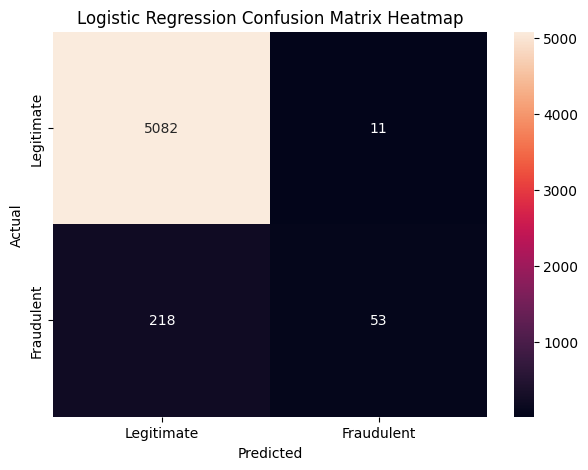

In [176]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("Logistic Regression Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

However, due to the huge imbalance between the two classes, legit (17000) and fraud (800), this model may not necessarily be as accurate as what we've gotten above.

So instead, what we can do is, randomly cut down our data that is of legit jobs so that the ratio of fraudulent to legitimate jobs in the training and test dataset is roughly 1:1.

**Data Balancing**

In [177]:
# data balancing
fraud_count = main_df[main_df['fraudulent'] == 1]
legit_count = main_df[main_df['fraudulent'] == 0]

legit_count_shuffled = legit_count.sample(frac=1, random_state=42)
filtered_dataset = legit_count_shuffled.head(len(fraud_count))
# this filtered dataframe is created by randomly picking 866 observations from the main_df where main_df['fraudulent'] == 0

#stitching back the two datasets.
combined_dataset = pd.concat([filtered_dataset, fraud_count], ignore_index=True)
combined_dataset = combined_dataset.sample(frac=1, random_state=42)

Y_reduced = combined_dataset.iloc[:,-1]
X_reduced = combined_dataset.iloc[:,:-1]

print(f"Shape of reduced Y: {Y_reduced.shape}")
print(f"Shape of reduced X: {X_reduced.shape}")

Shape of reduced Y: (1732,)
Shape of reduced X: (1732, 108)


In [178]:
# logistic regression on the new balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y_reduced, test_size=0.30, random_state=42)

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [179]:
y_pred_balanced_data = logistic_reg.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_balanced_data = accuracy_score(y_test, y_pred_balanced_data)

print("Logistic Regression Classification Report After Balancing Data:\n", classification_report(y_test, y_pred_balanced_data))

Logistic Regression Classification Report After Balancing Data:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       250
           1       0.79      0.77      0.78       270

    accuracy                           0.78       520
   macro avg       0.77      0.78      0.77       520
weighted avg       0.78      0.78      0.78       520



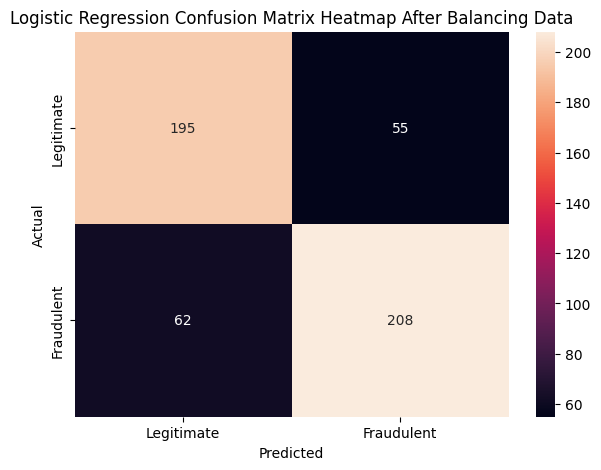

In [180]:
cm = confusion_matrix(y_test, y_pred_balanced_data)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("Logistic Regression Confusion Matrix Heatmap After Balancing Data")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

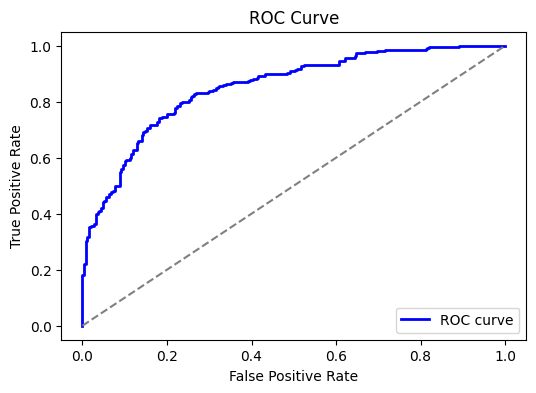

In [181]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg.predict_proba(X_test)[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

****Finding The Top 10 Most Common Words In Fraudulent Job Postings****

A bit of a detour, our dataset is now in perfect shape to figure out this question.

In [182]:
# creating a df of only the keywords
X_reduced_onlykeywords = X_reduced.iloc[:, :-8]
X_reduced_onlykeywords

keyword_importance = X_reduced_onlykeywords.sum(axis=0)

# keyword with the highest sum of importance
highest_importance_keyword = keyword_importance.idxmax()

print("Key word with the highest importance:", highest_importance_keyword)

Key word with the highest importance: work


In [183]:
top_10_keywords = keyword_importance.sort_values(ascending=False).head(10)

top_10_keywords_df = pd.DataFrame({'Keyword': top_10_keywords.index, 'Importance': top_10_keywords.values})

print("Top 10 most important words with their importance values:")
top_10_keywords_df

Top 10 most important words with their importance values:


,Keyword,Importance
0,work,223.854078
1,manag,155.210155
2,servic,154.588911
3,experi,152.777851
4,custom,152.041508
5,skill,132.305883
6,develop,132.195906
7,job,130.225368
8,amp,124.615800
9,posit,123.914036


In [184]:
# since some of the words are cut off due to stemming, we'll create a new, nicer dataframe with complete words
stemmed_to_full = {
    "manag": "manage",
    "servic": "service",
    "experi": "experience",
    "custom": "customer",
    "skill": "skill",
    "develop": "develop",
    "job": "job",
    "amp": "and",
    "posit": "position"
}

keyword_importance.index = keyword_importance.index.map(lambda x: stemmed_to_full.get(x, x))

top_10_keywords = keyword_importance.sort_values(ascending=False).head(10)

top_10_keywords_full_df = pd.DataFrame({'Keyword': top_10_keywords.index, 'Importance': top_10_keywords.values})

print("Top 10 most important words with their importance values:")
top_10_keywords_full_df

Top 10 most important words with their importance values:


,Keyword,Importance
0,work,223.854078
1,manage,155.210155
2,service,154.588911
3,experience,152.777851
4,customer,152.041508
5,skill,132.305883
6,develop,132.195906
7,job,130.225368
8,and,124.615800
9,position,123.914036


### **Model 2: Random Forest Classifier**

Random Forest Classifier makes sense for predicting fraudulent job postings because it can handle complex, non-linear relationships in text data, is robust to overfitting, provides feature importance insights, and most importantly, handles imbalanced data well.

**Random Forest Classifier with Entropy**

In [185]:
# with criterion = entropy
rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="entropy")

model = rfc.fit(X_train, y_train)

rfc.score(X_train,y_train)
rfc_predict = rfc.predict(X_test)
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       250
           1       0.90      0.89      0.89       270

    accuracy                           0.89       520
   macro avg       0.89      0.89      0.89       520
weighted avg       0.89      0.89      0.89       520



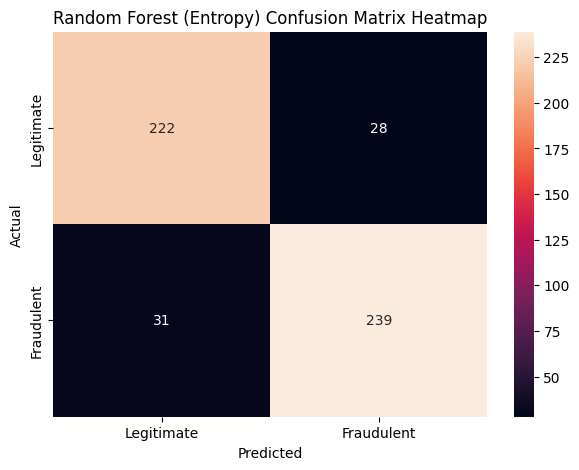

In [186]:
cm = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("Random Forest (Entropy) Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

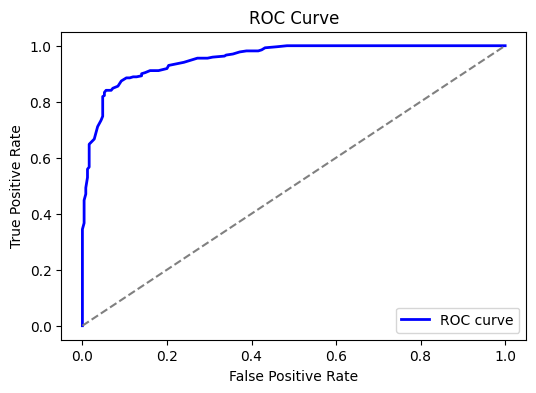

In [187]:
# ROC curve
y_pred_prob = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Random Forest Classifier with Gini Impurity**

In [188]:
# with criterion = gini
rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion="gini")
model = rfc.fit(X_train, y_train)
rfc_predict = rfc.predict(X_test)

print("Model Accuracy: ", rfc.score(X_test, y_test))
print(classification_report(y_test, rfc_predict))

Model Accuracy:  0.8961538461538462
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       250
           1       0.91      0.89      0.90       270

    accuracy                           0.90       520
   macro avg       0.90      0.90      0.90       520
weighted avg       0.90      0.90      0.90       520



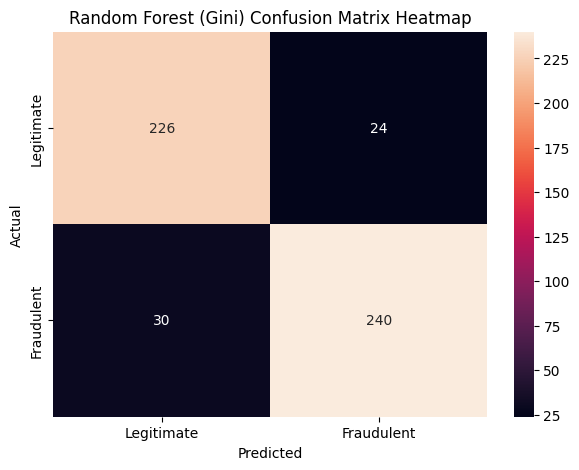

In [189]:
cm = confusion_matrix(y_test, rfc_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("Random Forest (Gini) Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

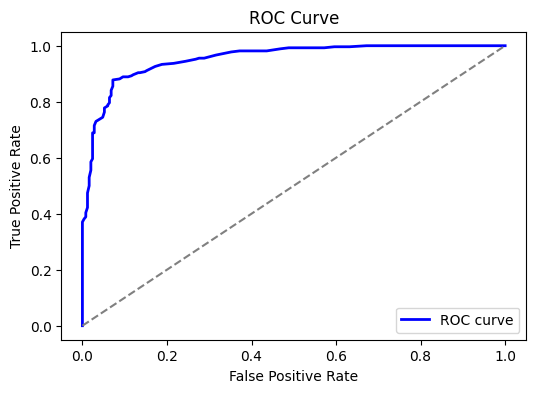

In [190]:
# ROC curve
y_pred_prob = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### **Model 3: Support Vector Machine Classifier**

In [191]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', probability=True)
model = svc.fit(X_train, y_train)

print("Train accuracy:", svc.score(X_train, y_train))

svc_predict = svc.predict(X_test)

print("Classification Report:\n", classification_report(y_test, svc_predict))

Train accuracy: 0.8605610561056105
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       250
           1       0.78      0.83      0.80       270

    accuracy                           0.79       520
   macro avg       0.79      0.79      0.79       520
weighted avg       0.79      0.79      0.79       520



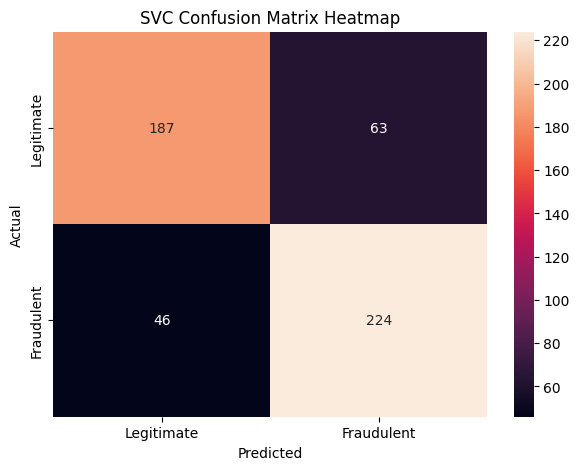

In [192]:
cm = confusion_matrix(y_test, svc_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("SVC Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

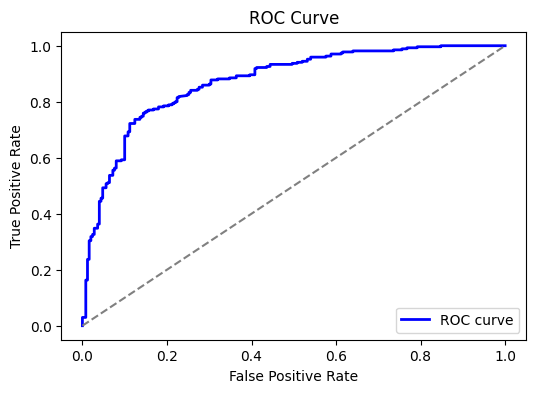

In [193]:
y_pred_prob = svc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### **Model 4: Naive Bayes Classifier**

In [194]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

mnb_predict = mnb.predict(X_test)

print("Classification Report:\n", classification_report(y_test, mnb_predict))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66       250
           1       0.69      0.67      0.68       270

    accuracy                           0.67       520
   macro avg       0.67      0.67      0.67       520
weighted avg       0.67      0.67      0.67       520



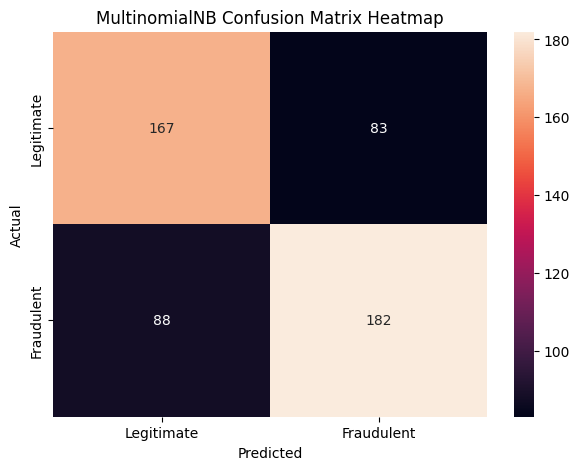

In [195]:
cm = confusion_matrix(y_test, mnb_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title("MultinomialNB Confusion Matrix Heatmap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Model 5: K-Nearest Neighbours model for the Categorical Variables

In [196]:
df_KNN = pd.read_csv("fake_job_postings.csv")
df_KNN

# analysis only on non text columns
df_KNN = df_KNN.iloc[:, 9:]
df_KNN

df_KNN = df_KNN.dropna()


In [197]:
# Calculate the count of fraudulent values equal to 1
count_fraudulent_1 = df_KNN['fraudulent'].sum()

# Sample rows where fraudulent is equal to 0
df_fraudulent_0_sampled = df_KNN[df_KNN['fraudulent'] == 0].sample(n=count_fraudulent_1, random_state=42)

# Subset rows where fraudulent is equal to 1
df_fraudulent_1 = df_KNN[df_KNN['fraudulent'] == 1]

# Concatenate the sampled DataFrame with the subset of rows where fraudulent is equal to 1
df_KNN_balanced = pd.concat([df_fraudulent_0_sampled, df_fraudulent_1])

# Shuffle the DataFrame to randomize the order of rows
df_KNN_balanced = df_KNN_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the balance of fraudulent values
print("Frequency of fraudulent values after balancing:")
print(df_KNN_balanced['fraudulent'].value_counts())


Frequency of fraudulent values after balancing:
fraudulent
1    342
0    342
Name: count, dtype: int64


In [198]:
X_KNN = df_KNN_balanced.iloc[: , :-1]
y_KNN = df_KNN_balanced.iloc[: , -1:]

In [199]:
from sklearn.preprocessing import LabelEncoder

# Define a list of categorical column names in X_knn
categorical_columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each categorical column and apply label encoding
for col in categorical_columns:
    X_KNN[col] = label_encoder.fit_transform(X_KNN[col])

In [200]:
X_KNN = X_KNN.values

In [201]:
X_KNN

array([[ 0,  1,  1, ...,  1, 17, 12],
       [ 0,  0,  0, ...,  1, 18, 23],
       [ 0,  1,  0, ...,  4, 41,  6],
       ...,
       [ 0,  1,  0, ...,  2, 46, 20],
       [ 0,  1,  1, ...,  0,  4, 12],
       [ 0,  1,  1, ...,  4, 19, 23]])

In [202]:
y_KNN = y_KNN.values

In [203]:
# Calculate frequency of values 0 and 1 in y_KNN
frequency_0 = (y_KNN == 0).sum()
frequency_1 = (y_KNN == 1).sum()

print("Frequency of 0:", frequency_0)
print("Frequency of 1:", frequency_1)

Frequency of 0: 342
Frequency of 1: 342


Accuracy: 0.8102189781021898
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        77
           1       0.78      0.78      0.78        60

    accuracy                           0.81       137
   macro avg       0.81      0.81      0.81       137
weighted avg       0.81      0.81      0.81       137



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



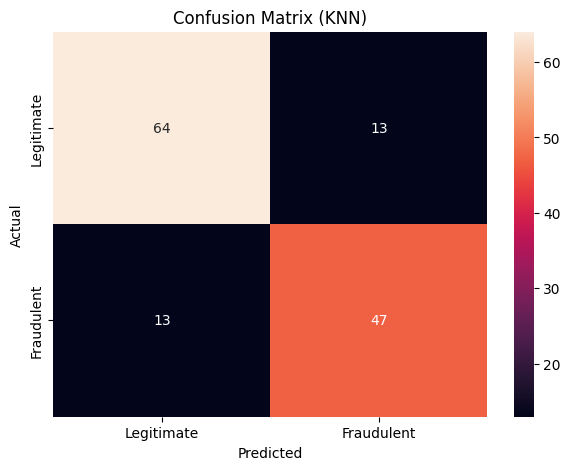

In [204]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_KNN, y_KNN, test_size=0.2, random_state=42)

# Initialize and fit KNN model
knn = KNeighborsClassifier(n_neighbors=4)  # You can adjust the number of neighbors as needed
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix (KNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Summary

In [205]:
logistic_regression_accuracy = 0.78
random_forest_entropy_accuracy = 0.89
random_forest_gini_accuracy = 0.90
svm_accuracy = 0.79
multinomial_nb_accuracy = 0.67
kNN_accuracy = 0.81

logistic_regression_precision = 0.78
random_forest_entropy_precision = 0.90
random_forest_gini_precision = 0.90
svm_precision = 0.78
multinomial_nb_precision = 0.69
kNN_precision = 0.78

logistic_regression_recall = 0.78
random_forest_entropy_recall = 0.90
random_forest_gini_recall = 0.87
svm_recall = 0.83
multinomial_nb_recall = 0.67
kNN_recall = 0.78

logistic_regression_f1 = 0.78
random_forest_entropy_f1 = 0.90
random_forest_gini_f1 = 0.89
svm_f1 = 0.80
multinomial_nb_f1 = 0.68
kNN_f1 = 0.78

classifiers = ['Logistic Regression', 'Random Forest (Entropy)', 'Random Forest (Gini)', 'SVM', 'Multinomial NB', 'kNN']
accuracies = [logistic_regression_accuracy, random_forest_entropy_accuracy, random_forest_gini_accuracy, svm_accuracy, multinomial_nb_accuracy, kNN_accuracy]
precisions = [logistic_regression_precision, random_forest_entropy_precision, random_forest_gini_precision, svm_precision, multinomial_nb_precision, kNN_precision]
recalls = [logistic_regression_recall, random_forest_entropy_recall, random_forest_gini_recall, svm_recall, multinomial_nb_recall, kNN_recall]
f1_scores = [logistic_regression_f1, random_forest_entropy_f1, random_forest_gini_f1, svm_f1, multinomial_nb_f1, kNN_f1]

df = pd.DataFrame(list(zip(classifiers, accuracies, precisions, recalls, f1_scores)), columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.78,0.78,0.78,0.78
1,Random Forest (Entropy),0.89,0.90,0.90,0.90
2,Random Forest (Gini),0.90,0.90,0.87,0.89
3,SVM,0.79,0.78,0.83,0.80
4,Multinomial NB,0.67,0.69,0.67,0.68
5,kNN,0.81,0.78,0.78,0.78
